# Exploring Spike Sorting Results in the Utah Organoids Pipeline


### **Overview**

This notebook provides a step-by-step exploration of spike sorting results, allowing users to analyze detected units and waveforms.

Spike sorting is the process of detecting, clustering, and labeling individual neurons' action potentials from extracellular recordings. The Utah Organoids pipeline performs this analysis using various clustering methods (e.g., Kilosort, SpykingCircus).

By the end of this notebook, you will:
- Select and inspect a spike sorting session
- Visualize sorted units and their spike times
- Explore waveforms and quality metrics for individual units

**_Note:_**

- This notebook uses example data, replace values with actual database entries.

### **Key Steps**

- **Setup**

- **Step 1: Select a Session of Interest**

- **Step 2: Explore Spike-Sorted Units**

- **Step 3: Explore Waveforms**

- **Step 4: Explore Quality Metrics**

#### **Setup**


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from workflow.pipeline import culture, ephys, probe

[2025-03-03 13:36:52,318][INFO]: Connecting milagros@db.datajoint.com:3306
[2025-03-03 13:36:54,033][INFO]: Connected milagros@db.datajoint.com:3306


#### **Step 1: Select a Session of Interest**


Check available experiments for a specific `organoid_id`:

In [6]:
(culture.Experiment & 'organoid_id="MB07"').proj(
    "experiment_end_time",
    "drug_name",
    "experiment_plan",
)

organoid_id e.g. O17,experiment_start_time,experiment_end_time,drug_name,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing"
MB07,2024-09-07 14:49:00,2024-09-07 15:02:00,Control,ephys


Define the session key:

In [7]:
session_key = dict(
    organoid_id="MB07",
    experiment_start_time="2024-09-07 14:49:00",
    insertion_number=0,
    start_time="2024-09-07 14:49:00",
    end_time="2024-09-07 14:54:00",
)

session_key

{'organoid_id': 'MB07',
 'experiment_start_time': '2024-09-07 14:49:00',
 'insertion_number': 0,
 'start_time': '2024-09-07 14:49:00',
 'end_time': '2024-09-07 14:54:00'}

Verify that the session exists:

In [8]:
ephys.EphysSession * ephys.EphysSessionInfo & session_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type,session_info Session header info from intan .rhd file. Get this from the first session file.
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,spike_sorting,=BLOB=


#### **Step 3: Explore Spike-Sorted Units**


Spike sorting results, including spike times and clustering information, are stored in the `ephys.CuratedClustering.Unit` table.

Retrieve detected units for the selected session:

In [10]:
ephys.CuratedClustering.Unit & session_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,electrode_config_hash,probe_type e.g. A1x32-6mm-100-177-H32_21mm,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,0,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,31,mua,13,=BLOB=,=BLOB=,=BLOB=
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,1,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,31,mua,14,=BLOB=,=BLOB=,=BLOB=
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,2,699af5e0-31fa-acc9-1aeb-132c6972d25e,A1x32-6mm-100-177-H32_21mm,31,mua,134,=BLOB=,=BLOB=,=BLOB=


Fetch and plot a raster plot for the first 3 units:

In [ ]:
# Fetching
units, unit_spiketimes = (ephys.CuratedClustering.Unit & session_key).fetch(
    "unit", "spike_times"
)

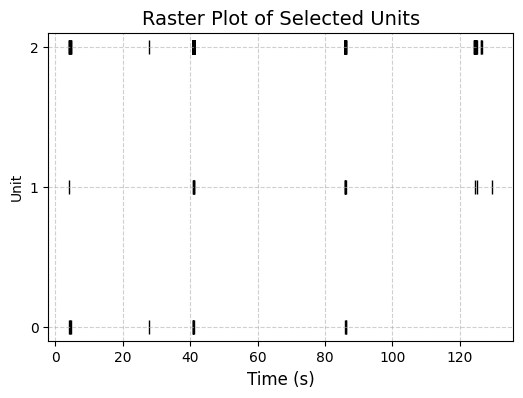

In [19]:
# Select subset of units to plot
units_subset = units[:3]
unit_spiketimes_subset = unit_spiketimes[:3]

# Flatten spike times and associate with unit indices
x = np.hstack(unit_spiketimes_subset)
y = np.hstack(
    [
        np.full_like(spike_times, unit_idx)
        for unit_idx, spike_times in zip(units_subset, unit_spiketimes_subset)
    ]
)

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(x, y, marker="|", color="black", s=100, linewidth=1)
# ax.set_xlim(min(x), max(x))
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_yticks([0, 1, 2])
ax.set_ylabel("Unit")

# Add grid for better readability
ax.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.title("Raster Plot of Selected Units", fontsize=14)
plt.show()


#### **Step 4: Explore Waveforms**


Waveform analysis helps assess the quality and consistency of detected units.

Fetch waveform information for the selected session:

In [20]:
ephys.WaveformSet & session_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250


In [21]:
ephys_key = dict(**session_key, paramset_idx=250)

In [23]:
ephys.WaveformSet.PeakWaveform & ephys_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,peak_electrode_waveform (uV) mean waveform for a given unit at its representative electrode
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,0,=BLOB=
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,1,=BLOB=
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,2,=BLOB=


#### Plotting Mean Waveform for a Given Unit at its Representative Electrode

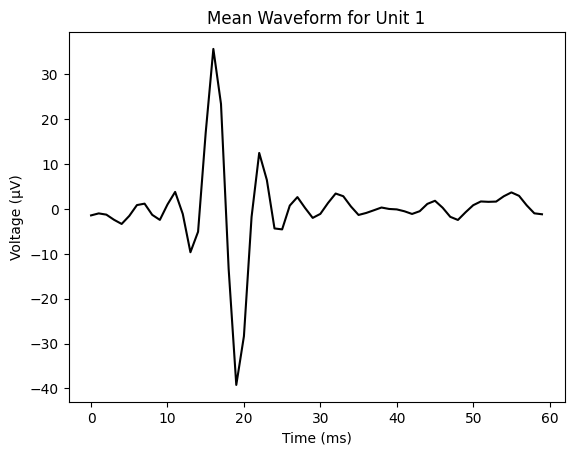

In [44]:
# Get waveform for unit = 1
unit = 1
waveform_data = (ephys.WaveformSet.PeakWaveform & ephys_key & f"unit={unit}").fetch1(
    "peak_electrode_waveform"
)


# Plot waveform
plt.figure()
plt.plot(waveform_data, color="black")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title(f"Mean Waveform for Unit {unit}")
plt.show()

In [45]:
# Plot the waveform and auto-correlogram
from element_array_ephys.plotting.unit_level import (
    plot_auto_correlogram,
    plot_waveform,
)

sampling_rate = (ephys.EphysSessionInfo & ephys_key).fetch1("session_info")[
    "sample_rate"
] / 1e3  # in kHz

peak_electrode_waveform, spike_times, cluster_quality_label = (
    (ephys.CuratedClustering.Unit & ephys_key & f"unit={unit}")
    * ephys.WaveformSet.PeakWaveform
).fetch1("peak_electrode_waveform", "spike_times", "cluster_quality_label")

# Get the figure
waveform_fig = plot_waveform(
    waveform=peak_electrode_waveform, sampling_rate=sampling_rate
)

correlogram_fig = plot_auto_correlogram(
    spike_times=spike_times, bin_size=0.001, window_size=1
)

display(waveform_fig)
display(correlogram_fig)

#### Plotting Mean Waveforms for All Detected Units


In [34]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & ephys_key).fetch("peak_electrode_waveform")
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sampling_rate  # ms

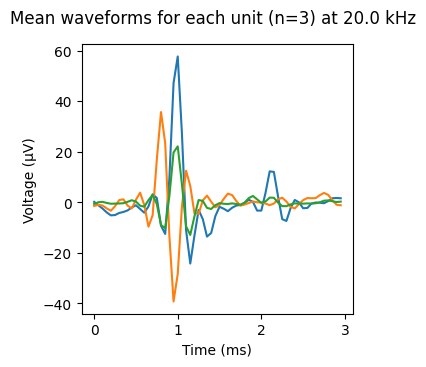

In [43]:
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx])
plt.suptitle(f"Mean waveforms for each unit (n={len(peak_wfs)}) at {sampling_rate} kHz")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.show()

#### **Step 5: Explore Quality Metrics**


Quality metrics help assess the reliability of spike-sorted units.

Check available quality metrics:

In [37]:
ephys.QualityMetrics & ephys_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250


In [39]:
ephys.QualityMetrics.Cluster & ephys_key

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,0,0.0433333,13.1681,0.4,591.716,1,nan,34389800000000.0,nan,1.65063,0.25,0.0523649,0.0534661,nan,nan,0.0
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,1,0.0466667,15.0743,0.6,0.0,0,nan,2992050000000000.0,nan,5.11831,0.607143,0.0,0.21984,nan,nan,0.0
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,2,0.446667,6.57527,0.6,250.613,45,nan,3021.65,0.0416452,2.15045,0.94403,0.37037,0.38304,nan,nan,1.0


In [40]:
ephys.QualityMetrics.Waveform & ephys_key


organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,0,-25.74,0.000155,0.00013,-0.414415,433346.0,-10732.0,200.0,nan,nan
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,1,-34.905,0.00015,0.000115,-0.319187,456380.0,-2251.97,200.0,nan,nan
MB07,2024-09-07 14:49:00,0,2024-09-07 14:49:00,2024-09-07 14:54:00,250,2,-16.2825,0.000155,0.00012,-0.577649,227517.0,-4557.35,200.0,nan,nan


### **Next Steps**

Now that you have explored spike sorting results, you can:
- Further analyze clustering results by downloading spike sorted data and running additional analyses.
- Compare spike sorting results across different sessions or experiments.